In [129]:
import pandas as pd

# Specify the file name
file_name = "한국환경공단_도로 재비산먼지 측정 정보_20241130.csv"

# Try reading the file with a different encoding
try:
    data = pd.read_csv(file_name, encoding="euc-kr")  # Adjust to "cp949" if needed
    print(data.head())
except UnicodeDecodeError as e:
    print(f"Error reading the file: {e}")
    print("Trying with a different encoding...")
    data = pd.read_csv(file_name, encoding="cp949")
    print(data.head())



         측정일자   측정시간  지역 지역명    도로명                    시작점  \
0  2024-11-01  16:04  인천  서구    에코로  인천광역시 서구 경서동 519-44 답   
1  2024-11-01  15:55  인천  서구   청라대로  인천광역시 서구 원창동 403-43 전   
2  2024-11-01  15:40  인천  서구    경제로      인천광역시 서구 연희동 821도   
3  2024-11-01  15:29  인천  서구  청라한울로    인천광역시 서구 경서동 855-5도   
4  2024-11-01  15:20  인천  서구  크리스탈로    인천광역시 서구 경서동 970-6도   

                      종점  기온  습도  재비산먼지 평균농도  오염범례  
0  인천광역시 서구 경서동 542-37 답  18  64          78    좋음  
1           인천광역시 서구 경서동  19  63          83    좋음  
2   인천광역시 서구 경서동 584-1 잡  19  63          15  매우좋음  
3    인천광역시 서구 경서동 837-8도  19  63          24  매우좋음  
4   인천광역시 서구 경서동 836-99도  19  64          37  매우좋음  


In [130]:
str(data) # Structure of the data frame

'            측정일자   측정시간  지역   지역명    도로명                     시작점  \\\n0     2024-11-01  16:04  인천    서구    에코로   인천광역시 서구 경서동 519-44 답   \n1     2024-11-01  15:55  인천    서구   청라대로   인천광역시 서구 원창동 403-43 전   \n2     2024-11-01  15:40  인천    서구    경제로       인천광역시 서구 연희동 821도   \n3     2024-11-01  15:29  인천    서구  청라한울로     인천광역시 서구 경서동 855-5도   \n4     2024-11-01  15:20  인천    서구  크리스탈로     인천광역시 서구 경서동 970-6도   \n...          ...    ...  ..   ...    ...                     ...   \n1281  2024-11-25  12:59  경기  동두천시    이담로    경기도 동두천시 지행동 160-3 도   \n1282  2024-11-25  12:54  경기  동두천시    행선로    경기도 동두천시 생연동 396-2 도   \n1283  2024-11-25  12:46  경기  동두천시    정장로    경기도 동두천시 생연동 820-1 도   \n1284  2024-11-25  12:12  경기  동두천시    강변로    경기도 동두천시 송내동 467-4 도   \n1285  2024-11-25  11:46  경기  동두천시    평화로  경기도 동두천시 하봉암동 157-11 도   \n\n                          종점  기온  습도  재비산먼지 평균농도  오염범례  \n0      인천광역시 서구 경서동 542-37 답  18  64          78    좋음  \n1               인천광역시 서구 경서동  19  63          83    

In [131]:
print(data.describe()) # Summary Statistics of the data frame

                기온           습도   재비산먼지 평균농도
count  1286.000000  1286.000000  1286.000000
mean     13.717729    47.773717    25.649300
std       4.860588    12.867755    41.837455
min       2.000000    17.000000     1.000000
25%      10.000000    40.000000     8.000000
50%      15.000000    49.000000    14.000000
75%      18.000000    56.000000    26.000000
max      22.000000    85.000000   555.000000


In [132]:
# Convert '측정일자' to datetime and extract numeric features
data['측정일자'] = pd.to_datetime(data['측정일자'])
data['측정년'] = data['측정일자'].dt.year
data['측정월'] = data['측정일자'].dt.month
data['측정일'] = data['측정일자'].dt.day
data.drop('측정일자', axis=1, inplace=True)  # Drop the original column

# Safely convert to datetime, coercing errors to NaT
data['측정시간'] = pd.to_datetime(data['측정시간'], format='%H:%M', errors='coerce')

# Drop or handle invalid entries (NaT values)
data = data.dropna(subset=['측정시간'])

# Convert '측정시간' to minutes since midnight
data['MinutesSinceMidnight'] = data['측정시간'].dt.hour * 60 + data['측정시간'].dt.minute

# Split '측정시간' into 'Hour' and 'Minute'
data['측정시'] = data['측정시간'].dt.hour
data['측정분'] = data['측정시간'].dt.minute

# Drop the original column if not needed
data.drop('측정시간', axis=1, inplace=True)
data.drop('MinutesSinceMidnight', axis=1, inplace=True)

In [133]:
print(data.head())

   지역 지역명    도로명                    시작점                     종점  기온  습도  \
0  인천  서구    에코로  인천광역시 서구 경서동 519-44 답  인천광역시 서구 경서동 542-37 답  18  64   
1  인천  서구   청라대로  인천광역시 서구 원창동 403-43 전           인천광역시 서구 경서동  19  63   
2  인천  서구    경제로      인천광역시 서구 연희동 821도   인천광역시 서구 경서동 584-1 잡  19  63   
3  인천  서구  청라한울로    인천광역시 서구 경서동 855-5도    인천광역시 서구 경서동 837-8도  19  63   
4  인천  서구  크리스탈로    인천광역시 서구 경서동 970-6도   인천광역시 서구 경서동 836-99도  19  64   

   재비산먼지 평균농도  오염범례   측정년  측정월  측정일  측정시  측정분  
0          78    좋음  2024   11    1   16    4  
1          83    좋음  2024   11    1   15   55  
2          15  매우좋음  2024   11    1   15   40  
3          24  매우좋음  2024   11    1   15   29  
4          37  매우좋음  2024   11    1   15   20  


In [134]:

# Encode the target class ("오염범례")
from sklearn.preprocessing import LabelEncoder

# Define the desired order for the target class
desired_order = ['매우나쁨', '나쁨', '보통', '좋음', '매우좋음']

# Create a mapping dictionary
custom_mapping = {label: index for index, label in enumerate(desired_order)}

# Map the '오염범례' column to the custom encoding
data['오염범례'] = data['오염범례'].map(custom_mapping)

# Verify the new encoding
print("Encoded to Original Mapping:", custom_mapping)
print(data['오염범례'].unique())



Encoded to Original Mapping: {'매우나쁨': 0, '나쁨': 1, '보통': 2, '좋음': 3, '매우좋음': 4}
[3 4 2 0 1]


In [135]:
# Remove numbers and everything after
data['시작점'] = data['시작점'].str.replace(r'\s\d+.*', '', regex=True)
data['종점'] = data['종점'].str.replace(r'\s\d+.*', '', regex=True)

print(data)


      지역   지역명    도로명            시작점             종점  기온  습도  재비산먼지 평균농도  오염범례  \
0     인천    서구    에코로   인천광역시 서구 경서동   인천광역시 서구 경서동  18  64          78     3   
1     인천    서구   청라대로   인천광역시 서구 원창동   인천광역시 서구 경서동  19  63          83     3   
2     인천    서구    경제로   인천광역시 서구 연희동   인천광역시 서구 경서동  19  63          15     4   
3     인천    서구  청라한울로   인천광역시 서구 경서동   인천광역시 서구 경서동  19  63          24     4   
4     인천    서구  크리스탈로   인천광역시 서구 경서동   인천광역시 서구 경서동  19  64          37     4   
...   ..   ...    ...            ...            ...  ..  ..         ...   ...   
1281  경기  동두천시    이담로   경기도 동두천시 지행동   경기도 동두천시 지행동  14  47          41     4   
1282  경기  동두천시    행선로   경기도 동두천시 생연동   경기도 동두천시 지행동  14  47          35     4   
1283  경기  동두천시    정장로   경기도 동두천시 생연동   경기도 동두천시 생연동  14  47         118     2   
1284  경기  동두천시    강변로   경기도 동두천시 송내동  경기도 동두천시 하봉암동  13  47          23     4   
1285  경기  동두천시    평화로  경기도 동두천시 하봉암동    경기도 양주시 봉양동  12  48          24     4   

       측정년  측정월  측정일  측정시  

In [136]:
# Create a label encoder instance
label_encoder = LabelEncoder()

# List of columns to encode
columns_to_encode = ['지역', '지역명', '도로명', '시작점', '종점']

# Dictionary to store the mappings
mappings = {}

# Apply label encoding and store the mapping
for col in columns_to_encode:
    data[col] = label_encoder.fit_transform(data[col])
    # Store the mapping for each column
    mappings[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mappings
for col, mapping in mappings.items():
    print(f"Mapping for column '{col}':")
    for original, encoded in mapping.items():
        print(f"  {original} -> {encoded}")
    print()


Mapping for column '지역':
  경기 -> 0
  경남 -> 1
  경북 -> 2
  광주 -> 3
  대구 -> 4
  대전 -> 5
  부산 -> 6
  서울 -> 7
  세종 -> 8
  울산 -> 9
  인천 -> 10
  전남 -> 11
  전북 -> 12
  충남 -> 13
  충북 -> 14

Mapping for column '지역명':
  강동구 -> 0
  강북구 -> 1
  강서구 -> 2
  경산시 -> 3
  경주시 -> 4
  계룡시 -> 5
  계양구 -> 6
  고성군 -> 7
  고양시 덕양구 -> 8
  고양시 일산동구 -> 9
  고양시 일산서구 -> 10
  공주시 -> 11
  관악구 -> 12
  광명시 -> 13
  광산구 -> 14
  광양시 -> 15
  광주시 -> 16
  광진구 -> 17
  구리시 -> 18
  구미시 -> 19
  군산시 -> 20
  군포시 -> 21
  금정구 -> 22
  기장군 -> 23
  김해시 -> 24
  나주시 -> 25
  남구 -> 26
  남동구 -> 27
  노원구 -> 28
  논산시 -> 29
  단양군 -> 30
  달서구 -> 31
  달성군 -> 32
  당진시 -> 33
  대덕구 -> 34
  도봉구 -> 35
  동구 -> 36
  동대문구 -> 37
  동두천시 -> 38
  동래구 -> 39
  동작구 -> 40
  마포구 -> 41
  목포시 -> 42
  미추홀구 -> 43
  보령시 -> 44
  부산진구 -> 45
  부여군 -> 46
  부천시 소사구 -> 47
  부천시 오정구 -> 48
  부천시 원미구 -> 49
  부평구 -> 50
  북구 -> 51
  사상구 -> 52
  사하구 -> 53
  서구 -> 54
  서산시 -> 55
  서천군 -> 56
  서초구 -> 57
  성남시 분당구 -> 58
  성남시 수정구 -> 59
  성남시 중원구 -> 60
  성북구 -> 61
  수성구 -> 62
  수영구 -> 

In [137]:
# Mapping of Korean column names to English
column_mapping = {
    '지역': 'Region',
    '지역명': 'Region_Name',
    '도로명': 'Road_Name',
    '시작점': 'Start_Point',
    '종점': 'End_Point',
    '기온': 'Temperature',
    '습도': 'Humidity',
    '재비산먼지 평균농도': 'Resuspended_Dust_Concentration',
    '오염범례': 'Pollution_Category',
    '측정년': 'Measurement_Year',
    '측정월': 'Measurement_Month',
    '측정일': 'Measurement_Day',
    '측정시': 'Measurement_Hour',
    '측정분': 'Measurement_Minute'
}

# Rename the columns
data.rename(columns=column_mapping, inplace=True)

# Check the updated DataFrame
print(data.head())


   Region  Region_Name  Road_Name  Start_Point  End_Point  Temperature  \
0      10           54        639          638        626           18   
1      10           54        879          642        626           19   
2      10           54         45          641        626           19   
3      10           54        886          638        626           19   
4      10           54        918          638        626           19   

   Humidity  Resuspended_Dust_Concentration  Pollution_Category  \
0        64                              78                   3   
1        63                              83                   3   
2        63                              15                   4   
3        63                              24                   4   
4        64                              37                   4   

   Measurement_Year  Measurement_Month  Measurement_Day  Measurement_Hour  \
0              2024                 11                1                16  

In [138]:
import numpy as np

class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature        # Feature to split on
        self.threshold = threshold    # Threshold value for split
        self.left = left              # Left subtree
        self.right = right            # Right subtree
        self.value = value            # Class label for leaf nodes

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        # Stop conditions
        if (depth >= self.max_depth or num_labels == 1 or num_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return DecisionTreeNode(value=leaf_value)

        # Find the best split
        best_feature, best_threshold = self._best_split(X, y, num_features)
        
        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return DecisionTreeNode(value=leaf_value)

        # Split the data
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold
        left = self._grow_tree(X[left_indices, :], y[left_indices], depth + 1)
        right = self._grow_tree(X[right_indices, :], y[right_indices], depth + 1)
        return DecisionTreeNode(feature=best_feature, threshold=best_threshold, left=left, right=right)

    def _best_split(self, X, y, num_features):
        best_gain = -1
        split_feature, split_threshold = None, None
        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(X, y, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_feature = feature
                    split_threshold = threshold
        return split_feature, split_threshold

    def _information_gain(self, X, y, feature, threshold):
        parent_entropy = self._entropy(y)

        left_indices = X[:, feature] <= threshold
        right_indices = X[:, feature] > threshold

        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        # Weighted average of child entropies
        n = len(y)
        n_left, n_right = len(y[left_indices]), len(y[right_indices])
        e_left, e_right = self._entropy(y[left_indices]), self._entropy(y[right_indices])
        child_entropy = (n_left / n) * e_left + (n_right / n) * e_right

        # Information gain
        return parent_entropy - child_entropy

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


In [139]:
# Features (excluding '오염범례') and target
X = data.drop(columns=['Pollution_Category']).select_dtypes(include=np.number).values
y = data['Pollution_Category'].values

# Initialize and train the tree
tree = DecisionTree(max_depth=5, min_samples_split=10)
tree.fit(X, y)

# Predict
predictions = tree.predict(X)
print(predictions)


[3 3 4 ... 2 4 4]


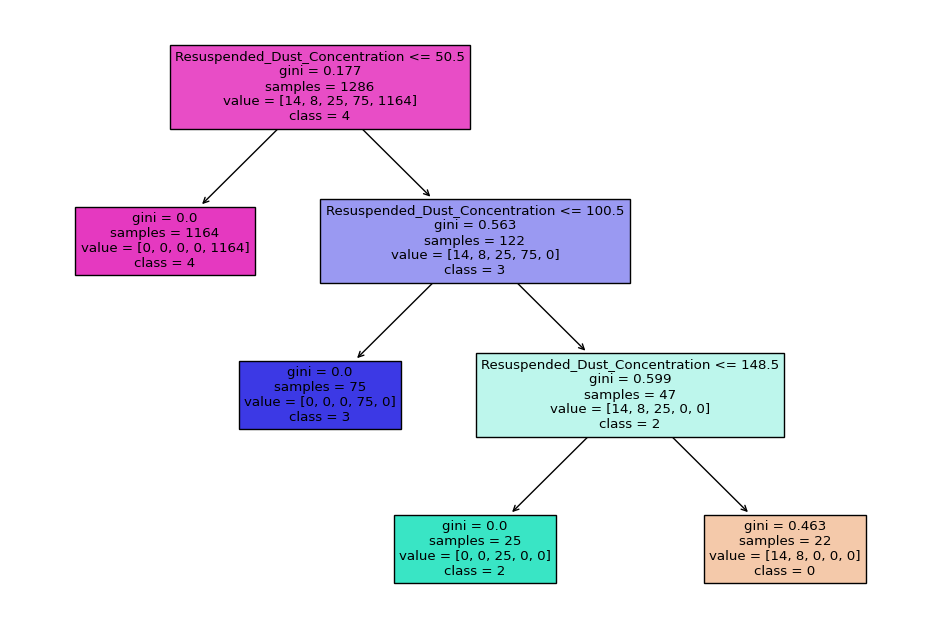

In [141]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Define the features (X) and target (y)
X = data.drop('Pollution_Category', axis=1)  # Use all columns except the target as features
y = data['Pollution_Category']  # Target column (already encoded)

# Define and fit the decision tree model
clf = DecisionTreeClassifier(max_depth=3, random_state=42)  # Adjust max_depth as needed
clf.fit(X, y)

# Plot the tree
plt.figure(figsize=(12, 8))
plot_tree(
    clf,
    feature_names=X.columns,  # Feature names
    class_names=[str(c) for c in sorted(custom_mapping.values())],  # Encoded class names
    filled=True
)
plt.show()


